<a href="https://colab.research.google.com/github/5sleepy/MNISTCNN/blob/main/firstCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size = 64, shuffle=True)

test_set = MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size = 64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 49234245.90it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1709628.03it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4672006.23it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10867386.63it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



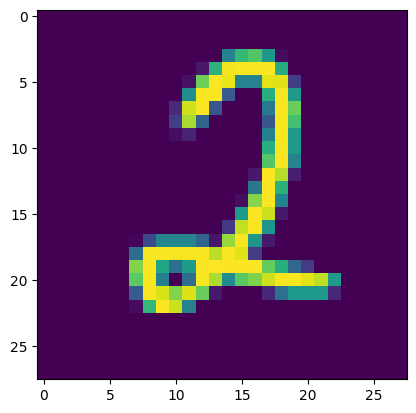

tensor(2)


In [5]:
x, y = next(iter(train_loader))
plt.imshow(x[0].squeeze())
plt.show()
print(y[0])

In [6]:
# define CNN architecture

class CNN(nn.Module):
  # took AlexNet and VGGNet architecture into consideration while doing this, as they've been pretty important (LOL) to computer vision
  # all CNNs i looked into generally had a large initial reduction of hxw, increasing channels instead
  # i chose fewer conv layers due to the simplicity of the dataset and pooling was inspired by predecessor architectures with proven effectiveness
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1) # 28x28x1 -> 28x28x32 -> 14x14x32 (pooling)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # 14x14x32 -> 14x14x64 -> 7x7x64 (pooling)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(7*7*64, 120)
    self.out = nn.Linear(120, 10)

  # considered including some form of dropout in the model, but ultimately decided it wasn't necessary due to the cleanliness of the data and small size

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 7*7*64) # flatten
    x = F.relu(self.fc1(x))
    x = self.out(x)
    return x


In [7]:
model = CNN()
criterion = nn.CrossEntropyLoss() # classification => cross entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.01) # implements ADAM optimization algorithm


In [8]:
# train model
losses = []
validation = []
train = []
epochs = 10

for epoch in range(epochs):
  model.train()
  correct_train=0
  total_train=0
  for batch, (X_batch, y_batch) in enumerate(train_loader):
    batch += 1
    optimizer.zero_grad()
    output = model(X_batch)
    loss = criterion(output, y_batch)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(output, 1)
    total_train += y_batch.size(0)
    correct_train += (predicted == y_batch).sum().item()


    if batch % 300 == 0:
      #print(f"Epoch: {epoch+1}, Batch: {batch}, Loss: {loss.item()}")
      losses.append(loss.item())

      checkpoint = {
          "epoch": epoch+1,
          "batch": batch,
          "model_state_dict": model.state_dict(),
          "optimizer_state_dict": optimizer.state_dict(),
          "loss": loss
      }

      torch.save(checkpoint, "checkpoint.pth")
  train.append(correct_train/total_train)

  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for X_batch, y_batch in test_loader:
      output = model(X_batch)
      _, predicted = torch.max(output, 1)
      total += y_batch.size(0)
      correct += (predicted == y_batch).sum().item()

    accuracy = correct/total
    validation.append(accuracy)
  print(f"Epoch: {epoch+1}, Accuracy: {accuracy}, Loss: {loss.item()}")


Epoch: 1, Accuracy: 0.9758, Loss: 0.27606308460235596
Epoch: 2, Accuracy: 0.975, Loss: 0.12688042223453522
Epoch: 3, Accuracy: 0.9787, Loss: 0.1256529986858368
Epoch: 4, Accuracy: 0.9792, Loss: 0.09642090648412704
Epoch: 5, Accuracy: 0.9778, Loss: 0.0033967134077101946
Epoch: 6, Accuracy: 0.9753, Loss: 0.03801531344652176
Epoch: 7, Accuracy: 0.9757, Loss: 0.0063976929523050785
Epoch: 8, Accuracy: 0.981, Loss: 0.0038409316912293434
Epoch: 9, Accuracy: 0.9816, Loss: 0.007204921450465918
Epoch: 10, Accuracy: 0.981, Loss: 0.001333018415607512


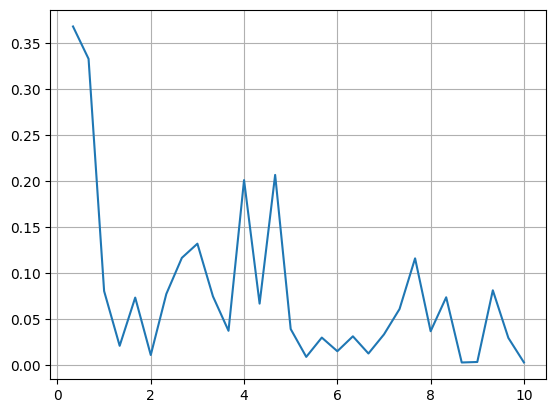

In [15]:
plt.plot([i/3 for i in range(1,31)], losses)
plt.grid(True)
plt.show()